<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_S/notebooks/Set_1_3_Model_C_ret_epoch100_oct15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Set_1_3 merged dataset, annotated, split in train/valid/test.

Train Model_B_ using Set_1_3 to generate Model_C.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Use annotated Set_1_3

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 2047, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2047 (delta 16), reused 7 (delta 7), pack-reused 2019
Receiving objects: 100% (2047/2047), 67.13 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (395/395), done.


In [4]:
!ls Surgical_instruments/Sets/Set_S/annotated
# merged dataset in Set_S contains Sets 1 - 3

README.md  test  train	valid


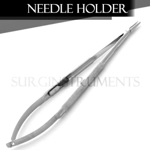

In [5]:
image_path = Path('Surgical_instruments/Sets/Set_S/annotated/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[201]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [6]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [10]:
# temporary
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
#!ls Surgical_instruments/Sets/Set_S/annotations/train
!ls gdrive/MyDrive/Surgical_instruments/Set_1_3.v1i.coco/valid

In [15]:
#path = Path('Surgical_instruments/Sets/Set_S/') # adjust if use git clone vs gdrive
path = Path('gdrive/MyDrive/Surgical_instruments/Set_1_3.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    #annotations_filepath = path/'annotations/train/Set_1_3_annotations.coco.json',
    annotations_filepath = path/'train/Set_1_3_annotations.coco.json',
    img_dir = path/'train'
    #img_dir = path/'annotated/train'
)

valid_parser = parsers.COCOBBoxParser(
    #annotations_filepath = path/'annotations/valid/Set_1_3_annotations.coco.json',
    annotations_filepath = path/'valid/Set_1_3_annotations.coco.json',
    img_dir = 'gdrive/MyDrive/Surgical_instruments/Set_1_3.v1i.coco/valid'
    #img_dir = path/'annotated/valid'
)

In [16]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/343 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/83 [00:00<?, ?it/s]

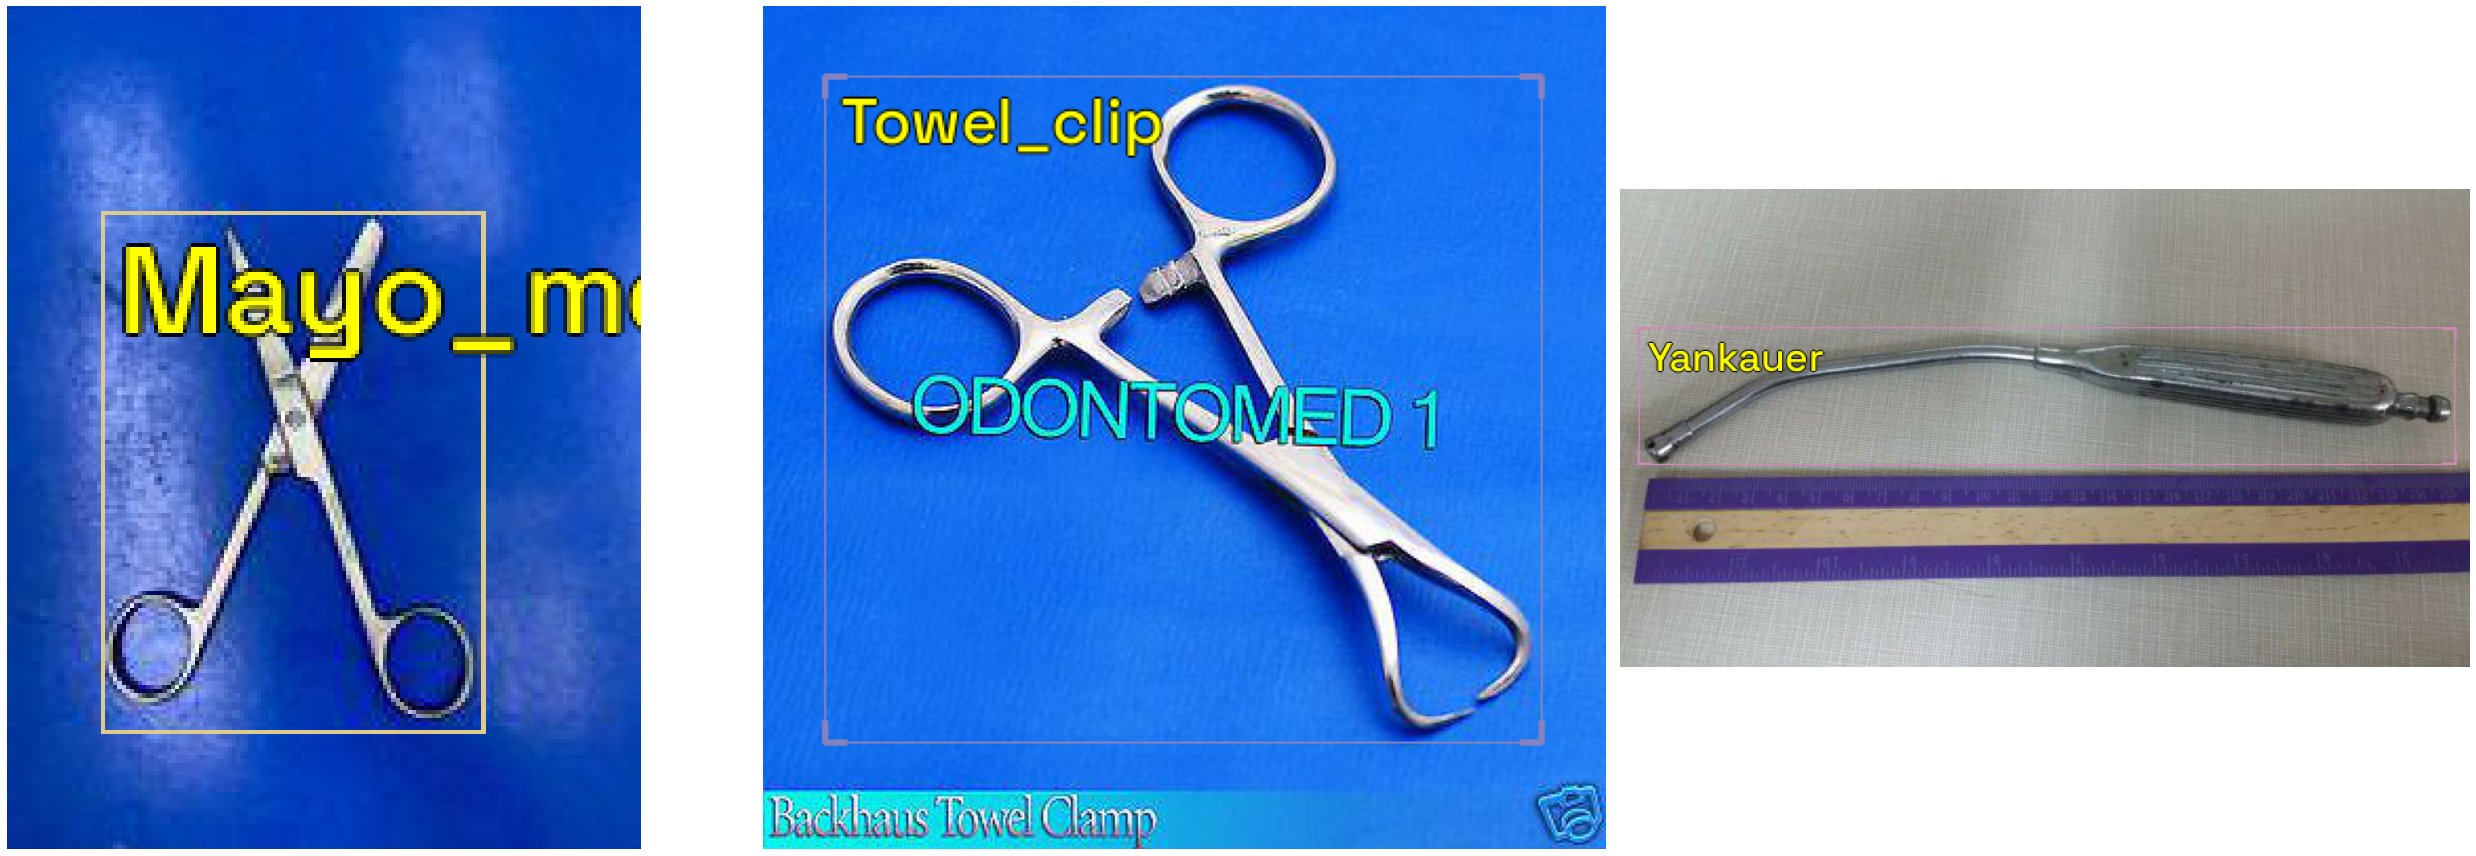

In [17]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

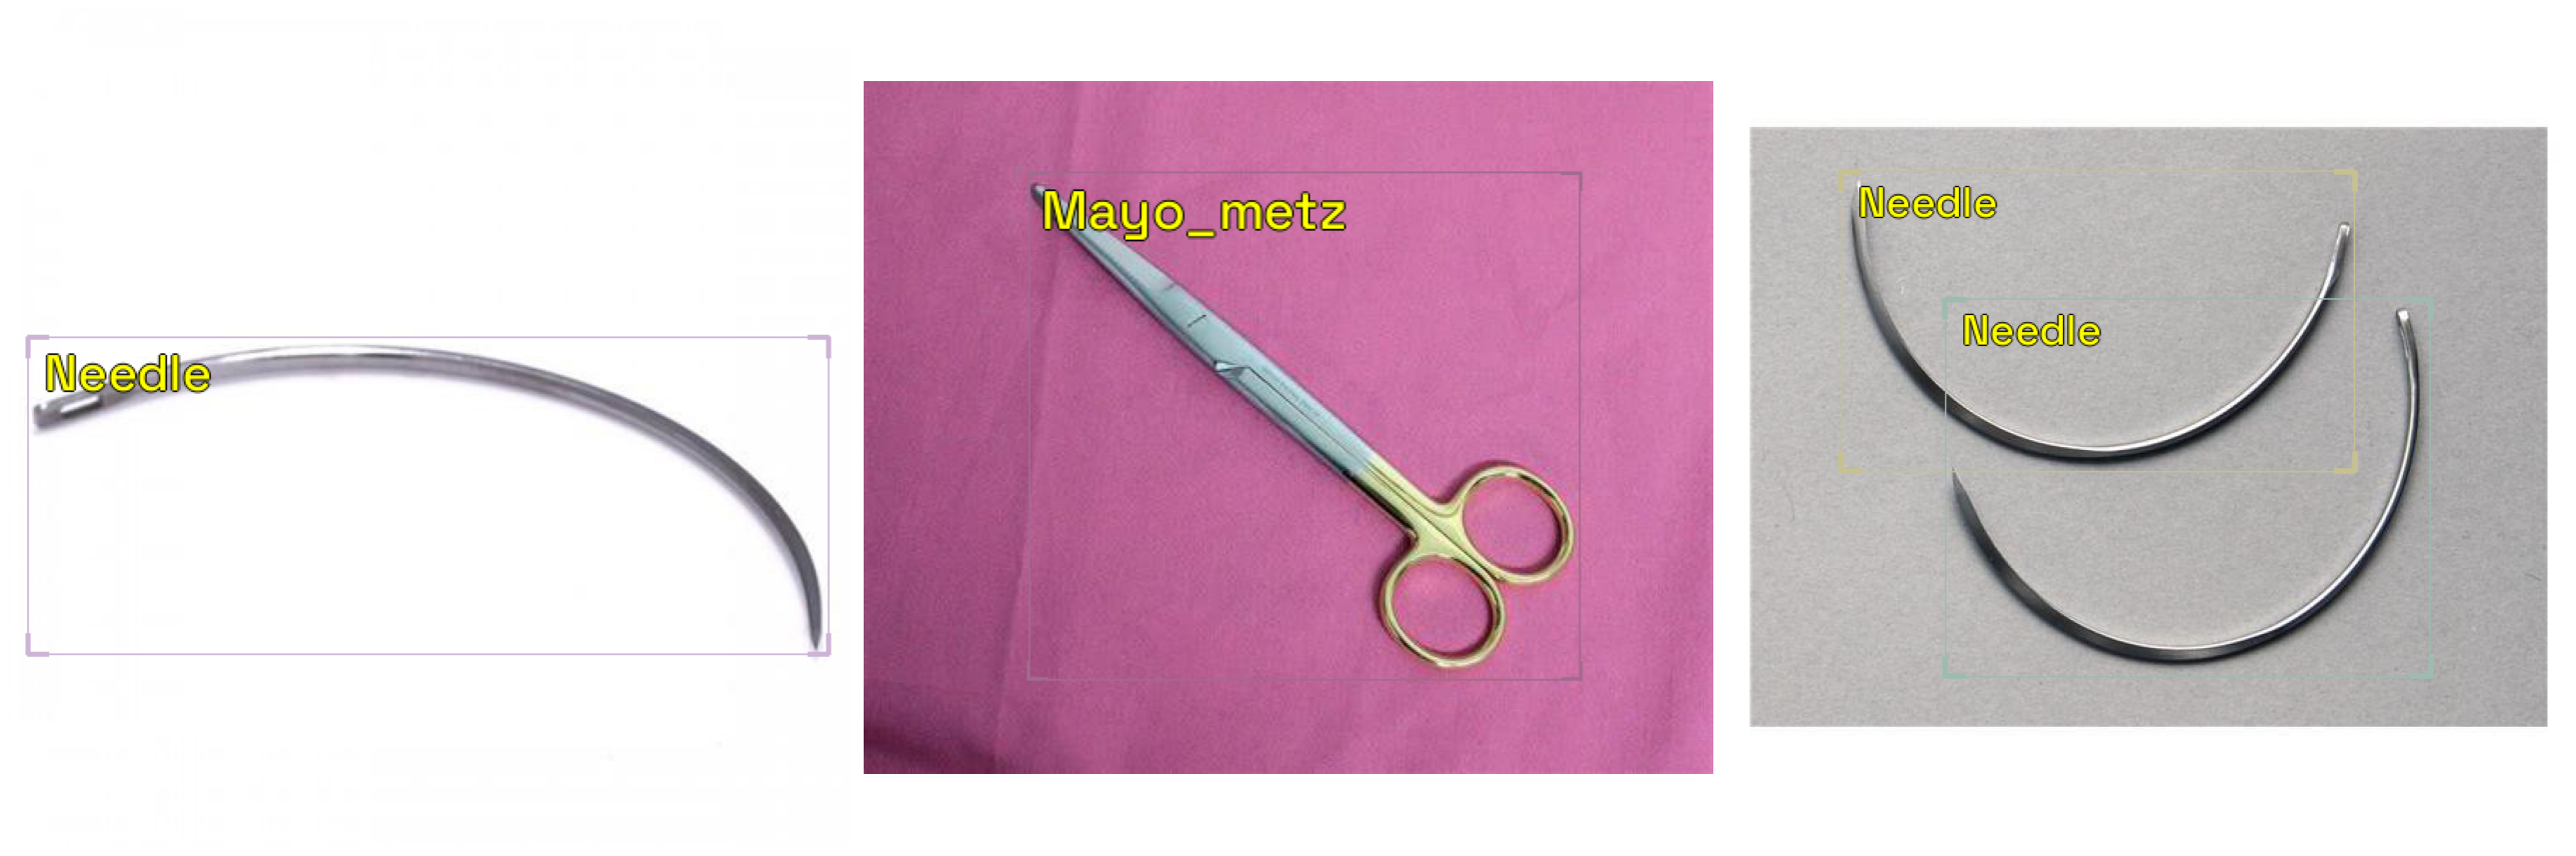

In [18]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [19]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [20]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train Model_B_ to generate teacher Model C using Set_1_3 merged.  

In [21]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x##

#model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args)

In [22]:
# temporary
from google.colab import files
files.upload()

Saving Model_B__ret_mAP44.3.pth to Model_B__ret_mAP44.3.pth


In [ ]:
checkpoint_path = 'Model_B__ret_mAP44.3.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [24]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
##
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Model_C_Set_1_3', reinit = True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback()) ##

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=8.31763736641733e-06)

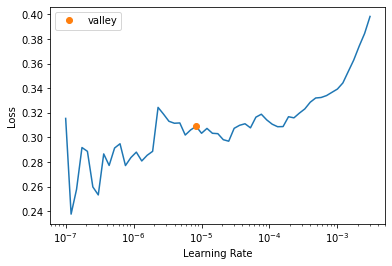

In [27]:
learn.lr_find()

In [28]:
# Set 1_3, retinanet, 
learn.fine_tune(100,8e-6)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


In [29]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

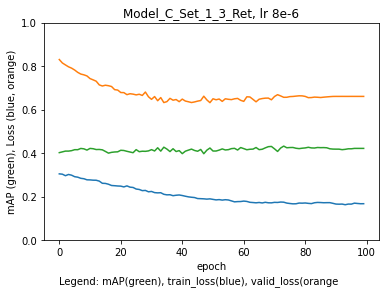

In [30]:
plot_metrics(learn, 'Model_C_Set_1_3_Ret, lr 8e-6')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


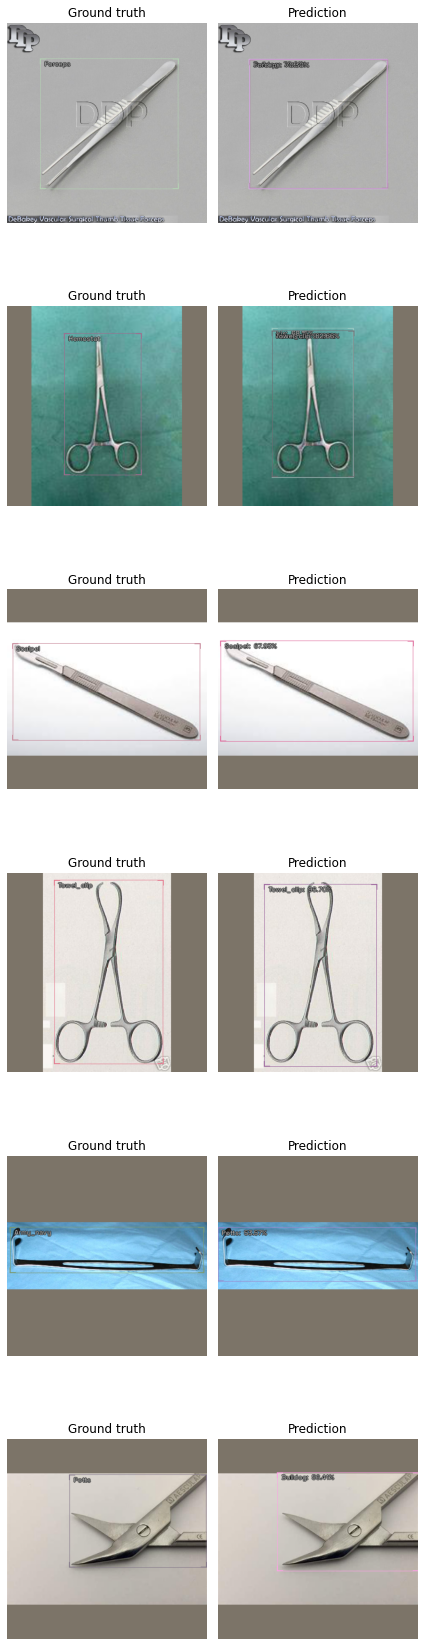

In [31]:
model_type.show_results(model, valid_ds)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


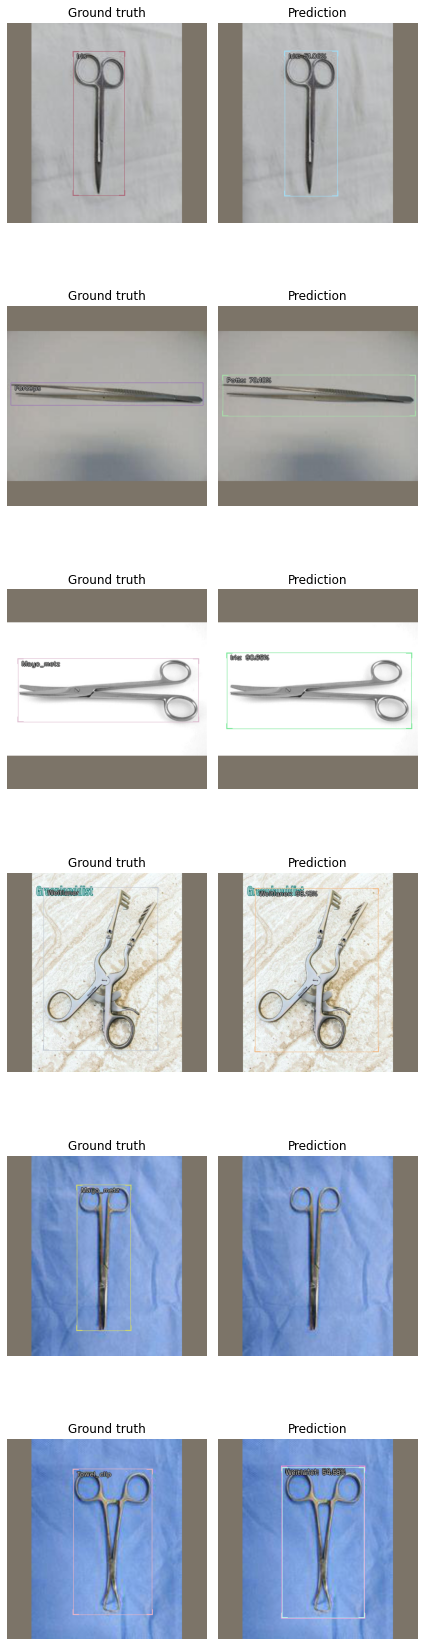

In [32]:
model_type.show_results(model, valid_ds)
# good valid preds

In [33]:
from icevision.models import *

checkpoint_path = 'Model_C_ret_mAP42.3.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

# download model

Inference for Set_4

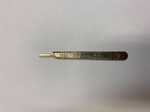

In [34]:
image_path = Path('Surgical_instruments/Sets/Set_4/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [35]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)

In [36]:
imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

Use Model C (trained on Set_1_3)

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_C_ret_mAP42.3.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model['model'] # Model C
model.eval()

Inference/ generate pseudolabels for Set_4 using Model C.

In [38]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


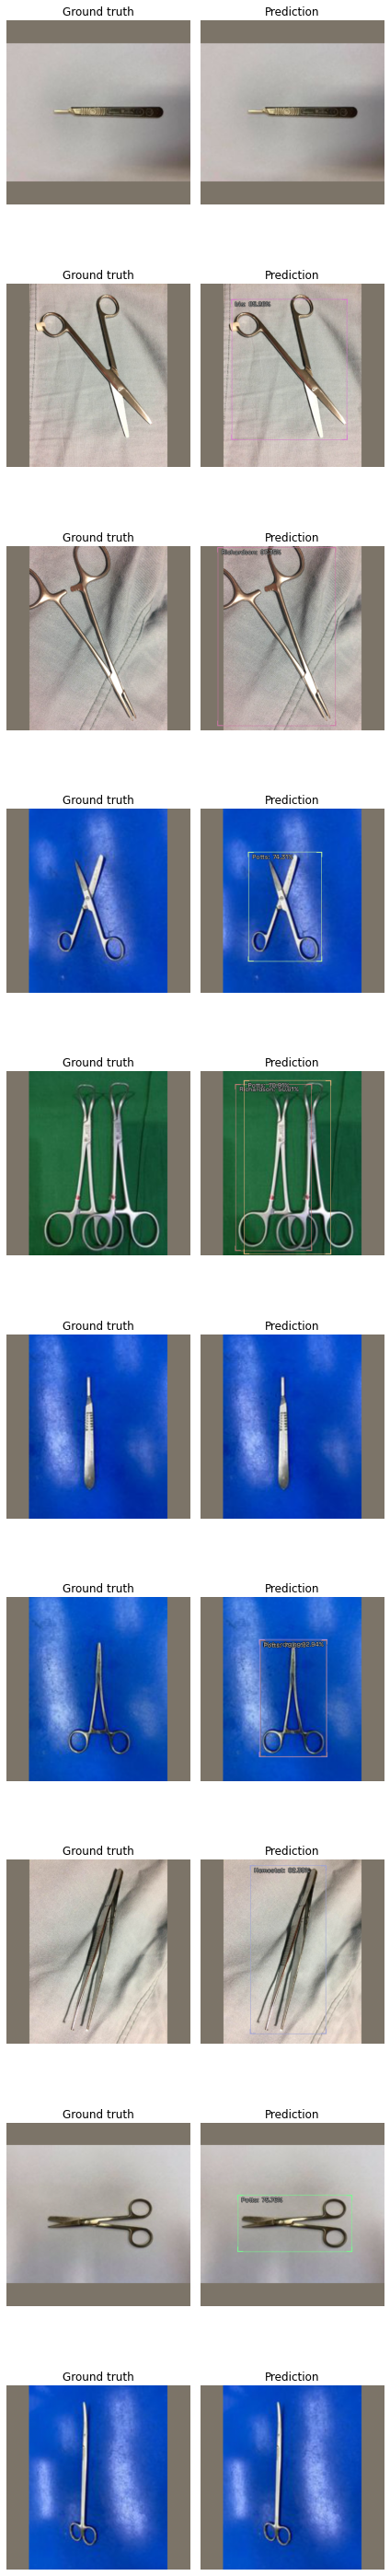

In [39]:
show_preds(preds = preds_saved[0:10])
# with detection threshold 0.5

Fair pseudolabels: some good bboxes, poor classification.

Use pseudolabels for annotation.



In [40]:
for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [41]:
add_info = {
    "info": {
        "year": "2021",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2021-10-05T20:13:09+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "instruments",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Army_navy",
            "supercategory": "Retractor"
        },
        {
            "id": 2,
            "name": "Bulldog",
            "supercategory": "Clamp"
        },
        {
            "id": 3,
            "name": "Castroviejo",
            "supercategory": "Needle_holder"
        },
        {
            "id": 4,
            "name": "Forceps",
            "supercategory": "Forceps"
        },
        {
            "id": 5,
            "name": "Frazier",
            "supercategory": "Suction"
        },
        {
            "id": 6,
            "name": "Hemostat",
            "supercategory": "Clamp"
        },
        {
            "id": 7,
            "name": "Iris",
            "supercategory": "Scissors"
        },
       {
            "id": 8,
            "name": "Mayo_metz",
            "supercategory": "Scissors"
        },
        {
            "id": 9,
            "name": "Needle",
            "supercategory": "Needle"
        },
        {
            "id": 10,
            "name": "Potts",
            "supercategory": "Scissors"
        },
        {
            "id": 11,
            "name": "Richardson",
            "supercategory": "Retractor"
        },
        {
            "id": 12,
            "name": "Scalpel",
            "supercategory": "Scalpel"
        },
        {
            "id": 13,
            "name": "Towel_clip",
            "supercategory": "Clamp"
        },
        {
            "id": 14,
            "name": "Weitlaner",
            "supercategory": "Retractor"
        },
        {
            "id": 15,
            "name": "Yankauer",
            "supercategory": "Suction"
        }
    ]
}

In [42]:
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()
##  edit ' to "": annot_.json

Refine annotation and split in Roboflow.

Continue iterative training.